In [1]:
import os
import time
import math

import torch
import torch.nn as nn
from torchvision import models
import model_impl
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_model_size(model: nn.Module) -> float:
    torch.save(model.state_dict(), "temp.pth")
    size = os.path.getsize("temp.pth")
    os.remove("temp.pth")
    return size / 1e6

def get_inference_time(model: nn.Module) -> float:
    image = torch.ones([1, 3, 224, 224])
    total = 0
    num_iter = 100
    
    for i in range(num_iter):
        cur = time.time()
        model(image)
        total += time.time() - cur
    
    return total / num_iter * 1000

def get_model_info(model: nn.Module):
    macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=False,
                                             print_per_layer_stat=False, verbose=True)
    model_size = get_model_size(model)
    inference_time = get_inference_time(model)
    return [macs / 1e9, params / 1e6, model_size, inference_time]

In [3]:
candidate = [(models.shufflenet_v2_x0_5(), 85.32), (models.squeezenet1_0(), 80.38),  (models.efficientnet_b0(), 75.70),
             (model_impl.MobileNetV1(), 89.9), (models.mnasnet1_0(), 93.3), (models.mobilenet_v3_large(), 92.32), (models.mobilenet_v2(), 90.3),
             (model_impl.SqNxt_23_1x_v5(), 82.42)]

model_info = []
for model, acc in candidate:
    model_info += [(model.__class__.__name__, acc, *get_model_info(model))]


C:\Users\jtige\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


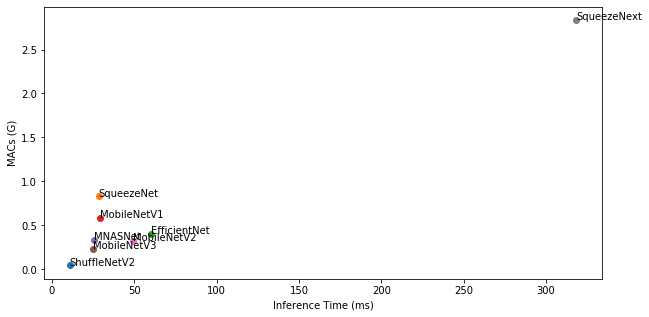

In [4]:
plt.figure(figsize=(10, 5))
for name, acc, macs, params, size, cost in model_info:
    plt.scatter(cost, macs)
    plt.annotate(name, (cost, macs))
    
plt.ylabel("MACs (G)")
plt.xlabel("Inference Time (ms)")
plt.show()

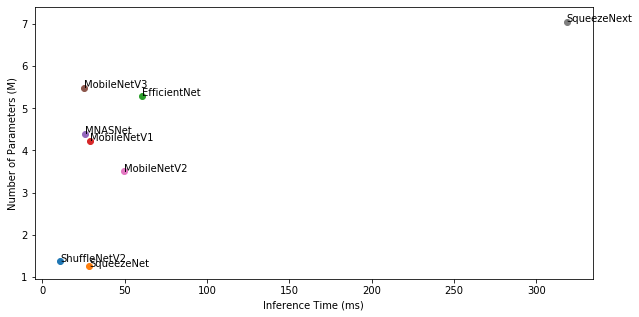

In [5]:
plt.figure(figsize=(10, 5))
for name, acc, macs, params, size, cost in model_info:
    plt.scatter(cost, params)
    plt.annotate(name, (cost, params))
    
plt.ylabel("Number of Parameters (M)")
plt.xlabel("Inference Time (ms)")
plt.show()

In [6]:
def get_net_score(acc, params, macs):
    a = 2
    b = 0.5
    y = 0.5
    
    return 20 * math.log(acc ** a / params ** b / macs ** y)

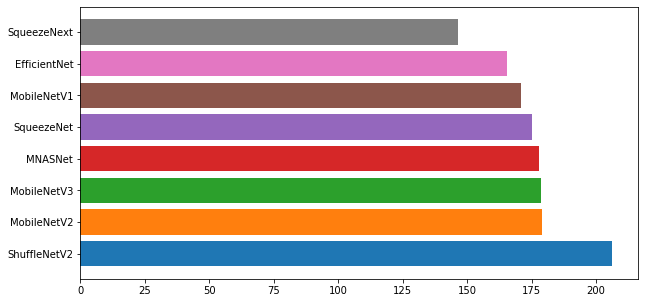

In [7]:
plt.figure(figsize=(10, 5))
res = []
for name, acc, macs, params, size, cost in model_info:
    res += [(get_net_score(acc, params, macs), name)]
res.sort(reverse=True)

for score, name in res:
    plt.barh(name, score)
plt.show()

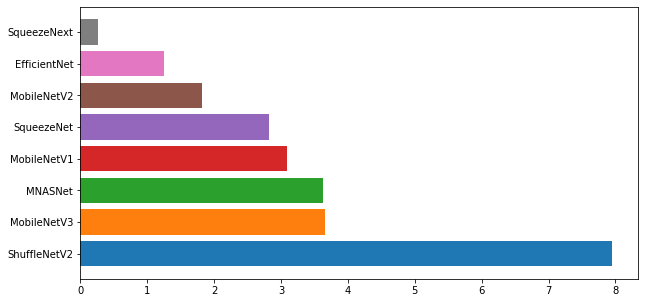

In [9]:
plt.figure(figsize=(10, 5))
res = []
for name, acc, macs, params, size, cost in model_info:
    res += [(acc / cost, name)]
res.sort(reverse=True)

for score, name in res:
    plt.barh(name, score)
plt.show()